# Import and functions

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd

%matplotlib inline

In [50]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [51]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# Set Parameter

In [52]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

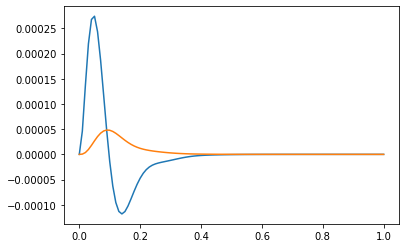

In [53]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [54]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [55]:
amp = 2
mean = 10
baseOutput = -np.convolve(np.hstack((np.zeros(len(k_E)), x))*amp+mean, -k_E, 'full')[len(k_E):len(k_E)+len(x)]

In [56]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

theta_star = 0

r = baseOutput
r = NL(r, np.mean(r) + theta_star*np.std(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [57]:
tv = ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt
#assign states
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
tvstate = EqualState(tv, state_num)[0]

baserstate = SG(baseOutput, dt, theta_star, 10, 2)
timeshift, baseMI = MIfunc(baserstate, xstate, dt, window, perSpike = True)

# +SFB

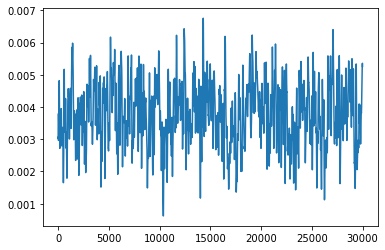

In [58]:
plt.plot(baseOutput)

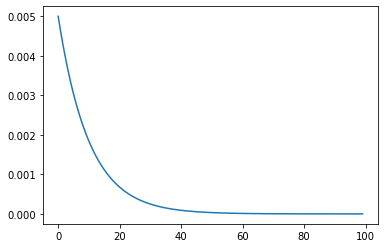

In [59]:
tau_P = 0.1 #s
sigma_b = 0.005
expDecay = np.exp(-np.arange(0,1,dt)/tau_P)*sigma_b
plt.plot(expDecay)

In [60]:
def SFB(input, expDecay, theta):
    test = 0
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    for i in range(len(h)):
        if h[i] > theta:
            rstate[i] = 1
            h[i+1:min(i+len(expDecay),len(h))] -= expDecay[1:min(len(expDecay),len(h)-i)]
    return rstate, h

In [61]:
theta = np.mean(baseOutput)+theta_star*np.std(baseOutput)
rstate, h = SFB(baseOutput, expDecay, theta)

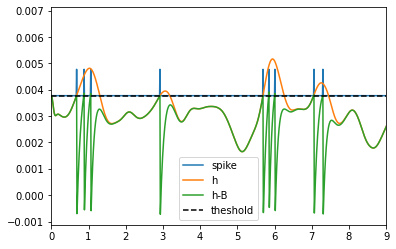

In [66]:
plt.plot(tAxis,rstate*sigma_b/5+theta, label = 'spike')

plt.plot(tAxis,baseOutput, label = 'h')
plt.plot(tAxis,h, label = 'h-B')
plt.plot(tAxis,np.ones_like(baseOutput)*theta, 'k--', label = 'theshold')
plt.xlim(0,9)
plt.legend()

In [63]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

Xcorr = np.correlate(x, rstate, 'same') / np.correlate(np.ones_like(x), rstate, 'same')
Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

timeshift, MI = MIfunc(rstate, xstate, dt, window, perSpike = True)

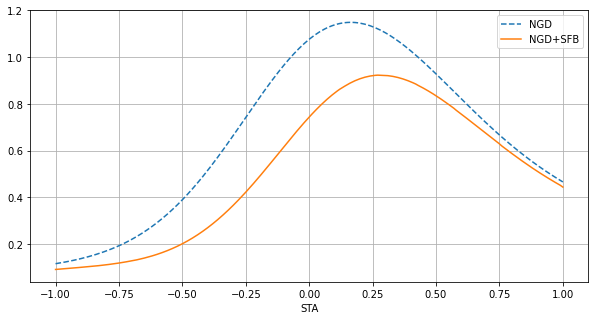

In [64]:
plt.plot(timeaxis,baseXcorr, label= 'NGD', linestyle= 'dashed' )
plt.plot(timeaxis,Xcorr, label= 'NGD+SFB')
plt.legend()
plt.xlabel('STA')
plt.grid('on')
plt.gcf().set_size_inches(10,5)

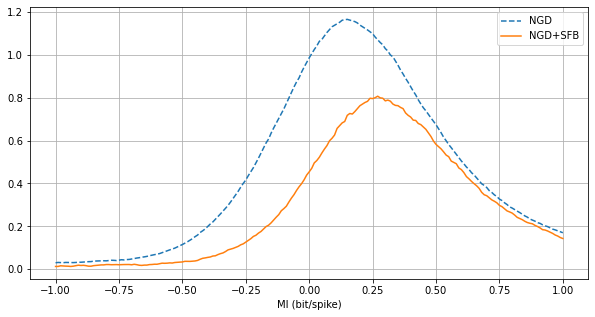

In [65]:
plt.plot(timeaxis,baseMI, label= 'NGD', linestyle= 'dashed' )
plt.plot(timeaxis,MI, label= 'NGD+SFB')
plt.legend()
plt.xlabel('MI (bit/spike)')
plt.grid('on')
plt.gcf().set_size_inches(10,5)